<a href="https://colab.research.google.com/github/kulight/fpt_clusttering/blob/master/encoder_clustering_fpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
np.random.seed(4881)
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Reshape,Input
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
tf.random.set_seed(4881)


import time

pd.options.display.max_columns = None
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
gpath = '/content/drive/My Drive/datasets/'
fpt = pd.read_csv(f'{gpath}five_p_eda.csv')

In [4]:
fpt = fpt.sample(n=20000, random_state=888)
fpt.shape

(20000, 56)

In [5]:
fpt = fpt.drop('cred_score', axis=1)
fpt.head()

EXT1  EXT2  EXT3  EXT4  EXT5  EXT6  EXT7  EXT8  EXT9  EXT10   EXT  \
443270   1.0   2.0   4.0   2.0   4.0   3.0   2.0   1.0   3.0    2.0  24.0   
108441   2.0   3.0   5.0   4.0   3.0   4.0   5.0   3.0   4.0    3.0  36.0   
37125    5.0   3.0   5.0   4.0   4.0   5.0   4.0   4.0   4.0    3.0  41.0   
548588   3.0   3.0   4.0   3.0   3.0   5.0   2.0   3.0   2.0    1.0  29.0   
485785   1.0   2.0   2.0   2.0   2.0   4.0   2.0   2.0   2.0    2.0  21.0   

        EST1  EST2  EST3  EST4  EST5  EST6  EST7  EST8  EST9  EST10   EST  \
443270   1.0   3.0   4.0   1.0   2.0   1.0   1.0   1.0   1.0    1.0  16.0   
108441   4.0   3.0   5.0   4.0   2.0   3.0   4.0   1.0   1.0    1.0  28.0   
37125    1.0   3.0   3.0   1.0   2.0   1.0   2.0   2.0   1.0    2.0  18.0   
548588   4.0   3.0   5.0   4.0   4.0   4.0   3.0   3.0   2.0    4.0  36.0   
485785   2.0   2.0   4.0   2.0   2.0   1.0   1.0   2.0   4.0    1.0  21.0   

        AGR1  AGR2  AGR3  AGR4  AGR5  AGR6  AGR7  AGR8  AGR9  AGR10   AGR  \
443270   1.0   3.0   5.0   4.0   4.0   5.0   5.0   2.0   4.0    4.0  37.0   
108441   1.0   5.0   5.0   5.0   3.0   5.0   5.0   4.0   5.0    5.0  43.0   
37125    5.0   4.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0    5.0  49.0   
548588   5.0   5.0   4.0   5.0   5.0   5.0   5.0   5.0   5.0    5.0  49.0   
485785   1.0   5.0   3.0   4.0   4.0   2.0   4.0   4.0   2.0    3.0  32.0   

        CSN1  CSN2  CSN3  CSN4  CSN5  CSN6  CSN7  CSN8  CSN9  CSN10   CSN  \
443270   4.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   4.0    4.0  47.0   
108441   4.0   4.0   4.0   4.0   5.0   4.0   5.0   3.0   5.0    3.0  41.0   
37125    4.0   5.0   4.0   5.0   5.0   4.0   5.0   5.0   5.0    5.0  47.0   
548588   1.0   2.0   5.0   1.0   1.0   1.0   2.0   3.0   1.0    3.0  20.0   
485785   5.0   5.0   4.0   4.0   3.0   5.0   5.0   3.0   5.0    5.0  44.0   

        OPN1  OPN2  OPN3  OPN4  OPN5  OPN6  OPN7  OPN8  OPN9  OPN10   OPN  
443270   3.0   4.0   4.0   4.0   4.0   5.0   4.0   3.0   4.0    4.0  39.0  
108441   3.0   4.0   4.0   4.0   4.0   4.0   4.0   2.0   4.0    4.0  37.0  
37125    5.0   5.0   4.0   5.0   5.0   5.0   5.0   5.0   4.0    5.0  48.0  
548588   5.0   5.0   5.0   5.0   4.0   5.0   5.0   3.0   5.0    5.0  47.0  
485785   3.0   5.0   2.0   5.0   4.0   1.0   5.0   4.0   4.0    3.0  36.0

In [6]:
fpt.shape

(20000, 55)

## Scaling all columns btween 0 and 1.

In [7]:
quests = ['EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7', 'EXT8', 'EXT9', 'EXT10',
         'EST1', 'EST2', 'EST3', 'EST4', 'EST5', 'EST6', 'EST7', 'EST8', 'EST9', 'EST10',
         'AGR1', 'AGR2', 'AGR3', 'AGR4', 'AGR5', 'AGR6', 'AGR7', 'AGR8', 'AGR9', 'AGR10',
         'CSN1', 'CSN2', 'CSN3', 'CSN4', 'CSN5', 'CSN6', 'CSN7', 'CSN8', 'CSN9', 'CSN10', 
         'OPN1', 'OPN2', 'OPN3', 'OPN4', 'OPN5', 'OPN6', 'OPN7', 'OPN8', 'OPN9', 'OPN10']

trait_sums = ['EXT', 'EST','AGR','CSN','OPN']

q_fpt = fpt[quests] / 5.0
q_fpt[trait_sums]= fpt[trait_sums] / 50

q_fpt.head()

EXT1  EXT2  EXT3  EXT4  EXT5  EXT6  EXT7  EXT8  EXT9  EXT10  EST1  \
443270   0.2   0.4   0.8   0.4   0.8   0.6   0.4   0.2   0.6    0.4   0.2   
108441   0.4   0.6   1.0   0.8   0.6   0.8   1.0   0.6   0.8    0.6   0.8   
37125    1.0   0.6   1.0   0.8   0.8   1.0   0.8   0.8   0.8    0.6   0.2   
548588   0.6   0.6   0.8   0.6   0.6   1.0   0.4   0.6   0.4    0.2   0.8   
485785   0.2   0.4   0.4   0.4   0.4   0.8   0.4   0.4   0.4    0.4   0.4   

        EST2  EST3  EST4  EST5  EST6  EST7  EST8  EST9  EST10  AGR1  AGR2  \
443270   0.6   0.8   0.2   0.4   0.2   0.2   0.2   0.2    0.2   0.2   0.6   
108441   0.6   1.0   0.8   0.4   0.6   0.8   0.2   0.2    0.2   0.2   1.0   
37125    0.6   0.6   0.2   0.4   0.2   0.4   0.4   0.2    0.4   1.0   0.8   
548588   0.6   1.0   0.8   0.8   0.8   0.6   0.6   0.4    0.8   1.0   1.0   
485785   0.4   0.8   0.4   0.4   0.2   0.2   0.4   0.8    0.2   0.2   1.0   

        AGR3  AGR4  AGR5  AGR6  AGR7  AGR8  AGR9  AGR10  CSN1  CSN2  CSN3  \
443270   1.0   0.8   0.8   1.0   1.0   0.4   0.8    0.8   0.8   1.0   1.0   
108441   1.0   1.0   0.6   1.0   1.0   0.8   1.0    1.0   0.8   0.8   0.8   
37125    1.0   1.0   1.0   1.0   1.0   1.0   1.0    1.0   0.8   1.0   0.8   
548588   0.8   1.0   1.0   1.0   1.0   1.0   1.0    1.0   0.2   0.4   1.0   
485785   0.6   0.8   0.8   0.4   0.8   0.8   0.4    0.6   1.0   1.0   0.8   

        CSN4  CSN5  CSN6  CSN7  CSN8  CSN9  CSN10  OPN1  OPN2  OPN3  OPN4  \
443270   1.0   1.0   1.0   1.0   1.0   0.8    0.8   0.6   0.8   0.8   0.8   
108441   0.8   1.0   0.8   1.0   0.6   1.0    0.6   0.6   0.8   0.8   0.8   
37125    1.0   1.0   0.8   1.0   1.0   1.0    1.0   1.0   1.0   0.8   1.0   
548588   0.2   0.2   0.2   0.4   0.6   0.2    0.6   1.0   1.0   1.0   1.0   
485785   0.8   0.6   1.0   1.0   0.6   1.0    1.0   0.6   1.0   0.4   1.0   

        OPN5  OPN6  OPN7  OPN8  OPN9  OPN10   EXT   EST   AGR   CSN   OPN  
443270   0.8   1.0   0.8   0.6   0.8    0.8  0.48  0.32  0.74  0.94  0.78  
108441   0.8   0.8   0.8   0.4   0.8    0.8  0.72  0.56  0.86  0.82  0.74  
37125    1.0   1.0   1.0   1.0   0.8    1.0  0.82  0.36  0.98  0.94  0.96  
548588   0.8   1.0   1.0   0.6   1.0    1.0  0.58  0.72  0.98  0.40  0.94  
485785   0.8   0.2   1.0   0.8   0.8    0.6  0.42  0.42  0.64  0.88  0.72

## creating df for all clustering methods.
'clust_fpt' will be used to aggregate and compare different cluster analyses.

In [8]:
train = clust_fpt = q_fpt

# Autoencoder

In [9]:
cols = 55

### Defining and compiling the autoencoder model

In [10]:
encoder = Sequential()
encoder.add(Dense(32, input_shape=[cols], activation="relu"))
encoder.add(Dense(16, activation="relu"))
encoder.add(Dense(4,activation="relu"))
encoder.add(Dense(4, activation="relu"))

decoder = Sequential()
decoder.add(Dense(16, input_shape=[4], activation='relu'))
decoder.add(Dense(32, activation='relu'))
decoder.add(Dense(cols, activation="relu"))

autoencoder = Sequential([encoder,decoder])
autoencoder.compile(loss="mse")

In [11]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 4)                 2408      
_________________________________________________________________
sequential_1 (Sequential)    (None, 55)                2439      
Total params: 4,847
Trainable params: 4,847
Non-trainable params: 0
_________________________________________________________________


### Training autoencoder model

In [12]:
train = train.iloc[:, :55]
autoencoder.fit(train, train, epochs=100, validation_data=(train, train))

Epoch 1/100
625/625 [==============================] - 2s 3ms/step - loss: 0.1862 - val_loss: 0.1755
Epoch 2/100
625/625 [==============================] - 2s 2ms/step - loss: 0.1590 - val_loss: 0.1525
Epoch 3/100
625/625 [==============================] - 5s 8ms/step - loss: 0.1479 - val_loss: 0.1460
Epoch 4/100
625/625 [==============================] - 4s 6ms/step - loss: 0.1460 - val_loss: 0.1457
Epoch 5/100
625/625 [==============================] - 2s 4ms/step - loss: 0.1457 - val_loss: 0.1459
Epoch 6/100
625/625 [==============================] - 2s 3ms/step - loss: 0.1456 - val_loss: 0.1454
Epoch 7/100
625/625 [==============================] - 2s 2ms/step - loss: 0.1454 - val_loss: 0.1450
Epoch 8/100
625/625 [==============================] - 1s 2ms/step - loss: 0.1407 - val_loss: 0.1373
Epoch 9/100
625/625 [==============================] - 1s 2ms/step - loss: 0.1372 - val_loss: 0.1369
Epoch 10/100
625/625 [==============================] - 2s 3ms/step - loss: 0.1371 - val_lo

### Using the encoder from the trained autoencoder to reduce dimentionality.

In [13]:
encoded_features = encoder.predict(train.iloc[:, :55])
enc_features = pd.DataFrame(encoded_features, columns = ['X1', 'X2','X3','X4'], index=q_fpt.index.copy())
# enc_features = pd.DataFrame(encoded_features, columns = ['X1', 'X2','X3'], index=train.index.copy())
enc_features.head()

X1        X2        X3   X4
443270  0.480478  1.083794  0.649223  0.0
108441  1.041468  1.126703  0.850349  0.0
37125   0.839749  1.515092  0.731103  0.0
548588  1.181381  0.503349  0.519642  0.0
485785  0.333032  0.890948  0.526012  0.0

# Identifing anomalies by loss score:

## Using autoencoder on the data and caculating loss between orginal data and autoencoded data.

In [14]:
predicted = pd.DataFrame(autoencoder.predict(train), index=train.index.copy(), columns=train.columns)
dist = np.linalg.norm(q_fpt - predicted, axis=-1)
clust_fpt['loss'] = dist

clust_fpt.head()

EXT1  EXT2  EXT3  EXT4  EXT5  EXT6  EXT7  EXT8  EXT9  EXT10  EST1  \
443270   0.2   0.4   0.8   0.4   0.8   0.6   0.4   0.2   0.6    0.4   0.2   
108441   0.4   0.6   1.0   0.8   0.6   0.8   1.0   0.6   0.8    0.6   0.8   
37125    1.0   0.6   1.0   0.8   0.8   1.0   0.8   0.8   0.8    0.6   0.2   
548588   0.6   0.6   0.8   0.6   0.6   1.0   0.4   0.6   0.4    0.2   0.8   
485785   0.2   0.4   0.4   0.4   0.4   0.8   0.4   0.4   0.4    0.4   0.4   

        EST2  EST3  EST4  EST5  EST6  EST7  EST8  EST9  EST10  AGR1  AGR2  \
443270   0.6   0.8   0.2   0.4   0.2   0.2   0.2   0.2    0.2   0.2   0.6   
108441   0.6   1.0   0.8   0.4   0.6   0.8   0.2   0.2    0.2   0.2   1.0   
37125    0.6   0.6   0.2   0.4   0.2   0.4   0.4   0.2    0.4   1.0   0.8   
548588   0.6   1.0   0.8   0.8   0.8   0.6   0.6   0.4    0.8   1.0   1.0   
485785   0.4   0.8   0.4   0.4   0.2   0.2   0.4   0.8    0.2   0.2   1.0   

        AGR3  AGR4  AGR5  AGR6  AGR7  AGR8  AGR9  AGR10  CSN1  CSN2  CSN3  \
443270   1.0   0.8   0.8   1.0   1.0   0.4   0.8    0.8   0.8   1.0   1.0   
108441   1.0   1.0   0.6   1.0   1.0   0.8   1.0    1.0   0.8   0.8   0.8   
37125    1.0   1.0   1.0   1.0   1.0   1.0   1.0    1.0   0.8   1.0   0.8   
548588   0.8   1.0   1.0   1.0   1.0   1.0   1.0    1.0   0.2   0.4   1.0   
485785   0.6   0.8   0.8   0.4   0.8   0.8   0.4    0.6   1.0   1.0   0.8   

        CSN4  CSN5  CSN6  CSN7  CSN8  CSN9  CSN10  OPN1  OPN2  OPN3  OPN4  \
443270   1.0   1.0   1.0   1.0   1.0   0.8    0.8   0.6   0.8   0.8   0.8   
108441   0.8   1.0   0.8   1.0   0.6   1.0    0.6   0.6   0.8   0.8   0.8   
37125    1.0   1.0   0.8   1.0   1.0   1.0    1.0   1.0   1.0   0.8   1.0   
548588   0.2   0.2   0.2   0.4   0.6   0.2    0.6   1.0   1.0   1.0   1.0   
485785   0.8   0.6   1.0   1.0   0.6   1.0    1.0   0.6   1.0   0.4   1.0   

        OPN5  OPN6  OPN7  OPN8  OPN9  OPN10   EXT   EST   AGR   CSN   OPN  \
443270   0.8   1.0   0.8   0.6   0.8    0.8  0.48  0.32  0.74  0.94  0.78   
108441   0.8   0.8   0.8   0.4   0.8    0.8  0.72  0.56  0.86  0.82  0.74   
37125    1.0   1.0   1.0   1.0   0.8    1.0  0.82  0.36  0.98  0.94  0.96   
548588   0.8   1.0   1.0   0.6   1.0    1.0  0.58  0.72  0.98  0.40  0.94   
485785   0.8   0.2   1.0   0.8   0.8    0.6  0.42  0.42  0.64  0.88  0.72   

            loss  
443270  1.380959  
108441  1.400124  
37125   1.353772  
548588  1.337265  
485785  1.521258

### Ploting loss ditribution
Can be used to detect anomalies as well as validating the model is reasoable.

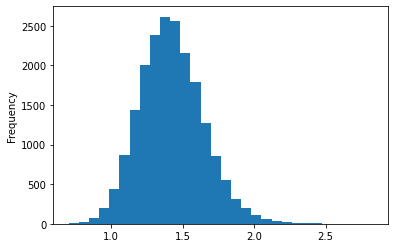

In [15]:
clust_fpt['loss'].plot.hist(bins=30);

In [16]:
clust_fpt['loss'].describe()

count    20000.000000
mean         1.421884
std          0.221565
min          0.701571
25%          1.267525
50%          1.410341
75%          1.562081
max          2.832811
Name: loss, dtype: float64

# Clustring by encoder features

## Linkage and dendogram

In [17]:
s_Z = linkage(enc_features, method='ward', metric='euclidean')

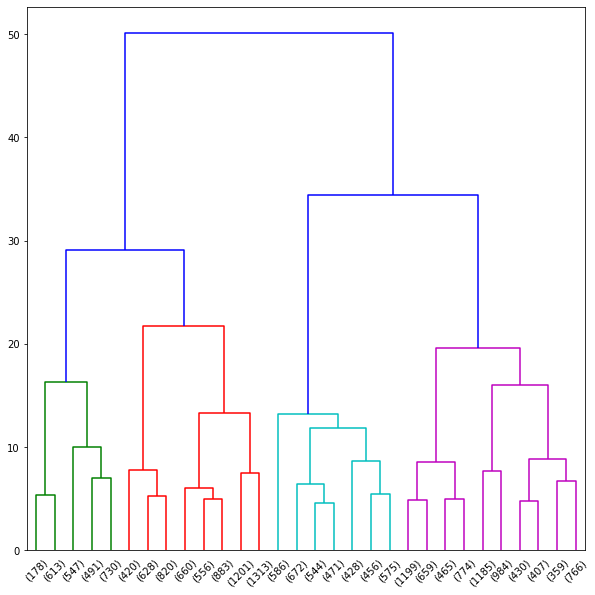

In [18]:
plt.figure(figsize=(10, 10))
s_dn = dendrogram(s_Z, color_threshold=29, truncate_mode='lastp', distance_sort=False)

## Clustering based on linkeage

In [19]:
s_cluster = fcluster(s_Z, t=29, criterion='distance')
s_unique, s_counts = np.unique(s_cluster, return_counts=True)
print(np.asarray((s_unique, s_counts)).T)
print(sum(s_counts))

[[   1 2559]
 [   2 6481]
 [   3 3732]
 [   4 7228]]
20000


In [20]:
color_map = {1: 'Green', 2 : 'Red', 3 : 'Blue', 4 : 'MediumPurple'}

In [21]:
clust_fpt['AutoEnc'] = s_cluster
enc_features['AutoEnc'] = s_cluster

## Ploting the clusters

In [22]:
import plotly.express as px

fig = px.scatter_3d(enc_features, x='X1', y='X2', z='X3', color='AutoEnc', width=1500, height=1000, color_discrete_map = color_map)
fig.update_traces(marker=dict(size=1.75))
fig.show()

Saving plot as html

In [23]:
fig.write_html("MyAmazingGrph.html")

# Interpreting inter-clusters variations  by backward classification

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.model_selection import train_test_split, GridSearchCV
# cross validation:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



## Defining functions for later use

In [25]:
def visualize_tree(model, md=5, width=800):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, class_names = True ,special_characters=True,filled=True, max_depth=md)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=width)

def print_dot_text(model, md=5):
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md)
    dot_text = dot_data.getvalue()
    print(dot_text)


## working with clust_fpt dataframe:

In [26]:
X = clust_fpt.drop(['AutoEnc','loss'], axis=1)
y = clust_fpt.AutoEnc

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.20,shuffle=True, stratify=clust_fpt.AutoEnc)

### CV method

In [27]:
my_cv = StratifiedShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2)

## Grid search parameters

In [28]:
my_param_grid = {'min_samples_leaf': [1,10,20, 40,100],
                 'min_weight_fraction_leaf': [ 0.005 ,0.01 ,0.1],
                 'criterion': ['gini', 'entropy'], 
                 'max_depth':[5, 7,10,15]}

## Defining DT and training model

In [29]:
dt_model= DecisionTreeClassifier()
dt_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [30]:
dt_model_gs = GridSearchCV(estimator=dt_model, 
                           param_grid=my_param_grid, 
                           cv=my_cv, 
                           scoring='neg_log_loss')

dt_model_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.2,
            train_size=0.8),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             

In [31]:
print("Best parameters:", dt_model_gs.best_params_)

Best parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.005}


In [32]:
dt_model_1 = dt_model_gs.best_estimator_

## Applying CV

In [33]:
-cross_val_score(dt_model_1, X_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([0.54445418, 0.49229891, 0.5513881 , 0.56828557, 0.64609226,
       0.50935778, 0.57307737, 0.51840677, 0.47973473, 0.57448583])

## Visualize tree and feature importance

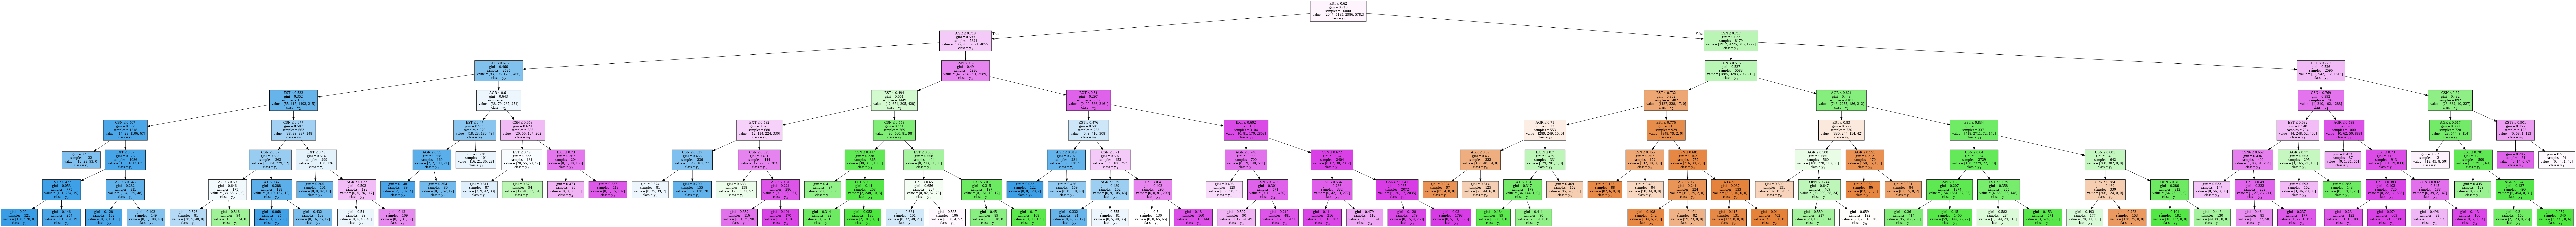

In [34]:
visualize_tree(dt_model_1, md=20, width=1200)

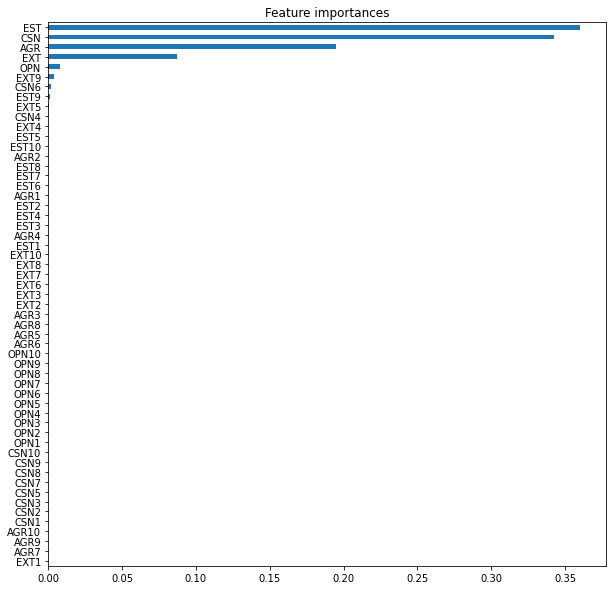

In [35]:
pd.Series(dt_model_1.feature_importances_, index=X_train.columns).sort_values()\
    .plot.barh(figsize=(10, 10), rot=0, title='Feature importances')

In [36]:
y_train_pred = pd.DataFrame(dt_model_1.predict_proba(X_train), columns=dt_model_1.classes_)

In [37]:
cm = confusion_matrix(y_true=y_train, y_pred=dt_model_1.predict(X_train))
print (cm)

[[1541  418   66   22]
 [ 320 4258  171  436]
 [  80  226 2275  405]
 [  28  362  432 4960]]


In [38]:
log_loss(y_train, y_train_pred)

0.4542394861868004

## DT model validation

In [39]:
y_test_pred = pd.DataFrame(dt_model_1.predict_proba(X_test), 
                        columns=dt_model_1.classes_)
log_loss(y_test, y_test_pred)

0.5533918520484653

### According to DT classifier the most important features in classification to auto-encoder's clusters are: 
1. EXT
2. EST
3. OPN

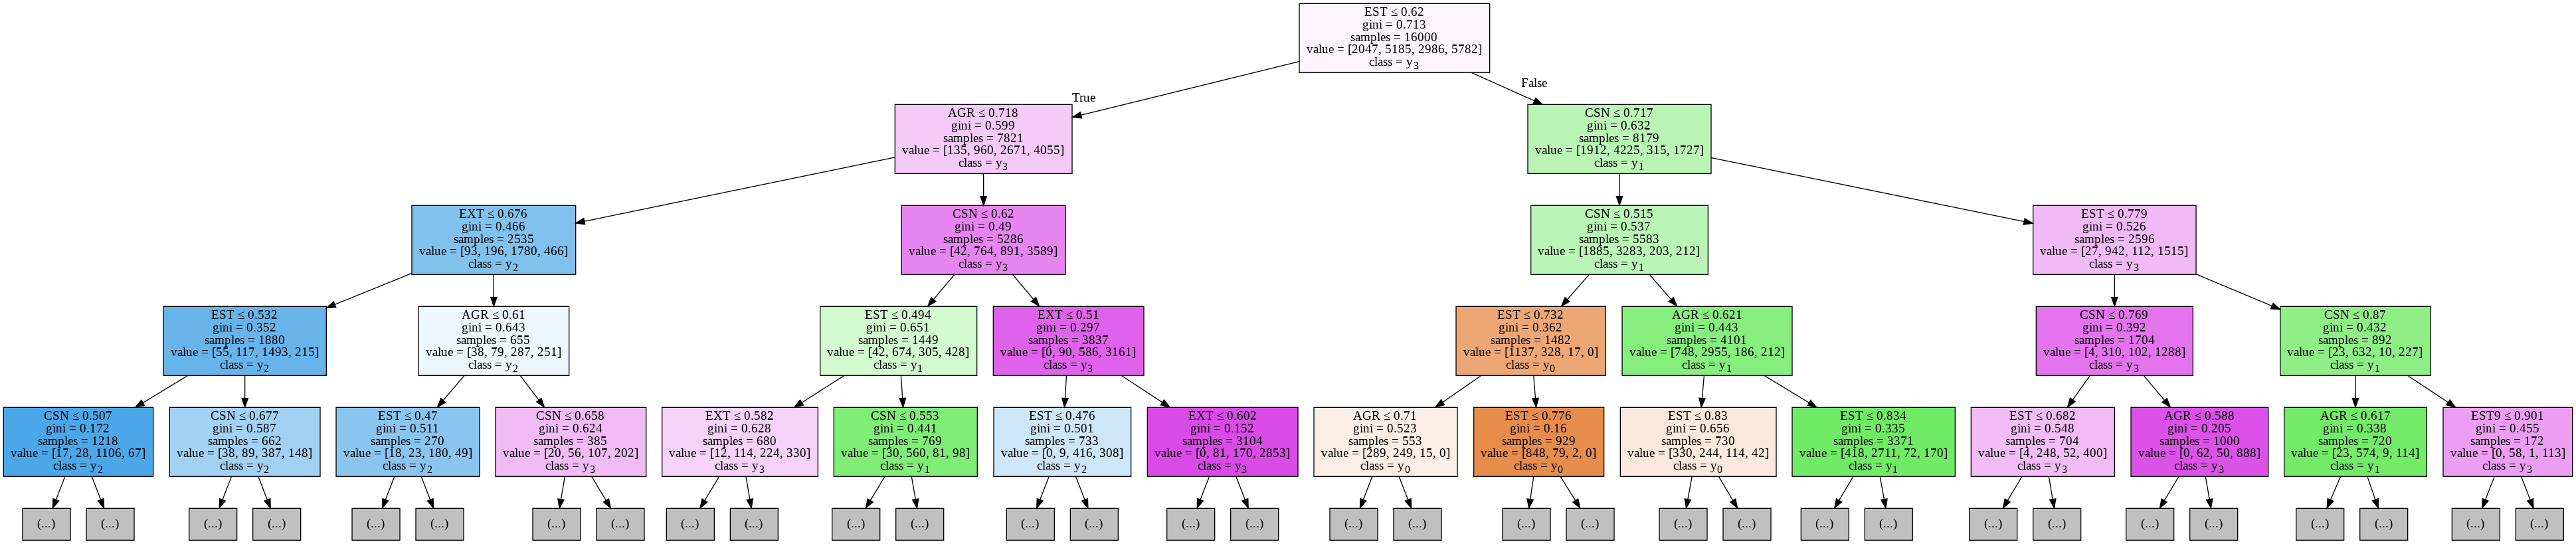

In [40]:
visualize_tree(dt_model_1, md=4, width=600)

In [41]:
import plotly.express as px

fig = px.scatter_3d(clust_fpt, x='EST', y='CSN', z='AGR', color='AutoEnc', width=1500, height=1000, color_discrete_map = color_map)
fig.update_traces(marker=dict(size=1.75))
fig.show()

## Grouping clusters by axes means

In [42]:
grouped = clust_fpt.groupby('AutoEnc').agg(
    EXT_mean=('EXT', np.mean),
    OPN_mean=('OPN', np.mean),
    CSN_mean=('CSN', np.mean),
    AGR_mean=('AGR', np.mean),
    EST_mean=('EST', np.mean)).reset_index()

grouped

AutoEnc  EXT_mean  OPN_mean  CSN_mean  AGR_mean  EST_mean
0        1  0.573604  0.799583  0.485305  0.672180  0.799158
1        2  0.577981  0.760549  0.620275  0.794331  0.710537
2        3  0.484841  0.757972  0.681129  0.644702  0.466435
3        4  0.666558  0.786208  0.770410  0.808402  0.530129

In [43]:
import plotly.graph_objects as go
categories = ['Extroversion', 'Openness', 'Conscientiousness', 'Agreeableness', 'Neuroticism']
fig =  go.Figure()

layout = dict(radialaxis=dict(visible=True, range=[0,1]))

for (_, cluster, col0, col1, col2, col3, col4) in grouped.itertuples(name=None):
    fig.add_trace(go.Scatterpolargl(r=[col0, col1, col2, col3, col4], theta=categories, name=f'cluster {cluster}'))
          
fig.update_layout(polar1=layout, showlegend=True, height=700, width=700)
fig.show()